# Analysis and Plotting of Earthquake Catalogue Location Quality Scores 

This code is designed to accompany the manuscript Warren-Smith et al., 2023, submitted to NZJGG.

## 1. Imports

In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

import numpy as np
import os

from shapely.geometry import Point, Polygon

from obspy import UTCDateTime, read_events, Catalog
from obspy.clients.fdsn import Client
from obspy.clients.fdsn.client import FDSNRequestTooLargeException

from helpers.nz_polygons import KNOWN_REGIONS, extract_polygon
from helpers.catalog_functions import (
    quality_measures_check, assign_variables, min_spick_dist, 
    binary_counts)
from helpers.plotting import (
    plot_catalog, plot_azimuthal_map, plot_depth_scatter,
    plot_quality_criteria_scores, plot_quality_score_map,
    plot_quality_score_bar)

# 2. Get a catalog of interest
We can select a more precise region in the next cell, so just get a catalog that at least encompasses your region of interest.
Here we use a catalog from an FDSN client, but you could also read one from disk, or get one from another supplier.

In [2]:
# Define client used to download catalog
client = Client("GEONET")

# Define start and end dates and any constraint on depth
starttime = UTCDateTime(2018, 1, 1) 
endtime = UTCDateTime(2023, 1, 1) 
maxdepth = 50

# Define an initial quadrilateral of interest, which can then be filtered by a polygon region later
maxlatitude = -37.345
minlatitude = -39.1
minlongitude = 176.6
maxlongitude = 178.85

bounds = f"{maxlatitude}-{minlatitude}_{maxlongitude}-{minlongitude}"

In [3]:
# Define output/input location for catalogue
cat_out = f"temp_files/{bounds}_{starttime.strftime('%Y')}_{endtime.strftime('%Y')}_depth{maxdepth}.xml"

# We will store temporary files in the temp_files directory.
if not os.path.isdir("temp_files"):
    os.makedirs("temp_files")

#if haven't alreasy generated catalogue make it from client, or read in regional catalog if exists already
if not os.path.exists(cat_out):
    print("No existing catalogue for selection: downloading from client")
    fdsn_kwargs = dict(
        maxlatitude=maxlatitude, minlatitude=minlatitude,
        maxlongitude=maxlongitude, minlongitude=minlongitude, 
        maxdepth=maxdepth)
    try:
        cat = client.get_events(
            starttime=starttime, endtime=endtime, **fdsn_kwargs)
    except FDSNRequestTooLargeException:
        print("Request too large, splitting into chunks")
        chunk_size = 365 * 86400
        _starttime, _endtime = starttime, starttime + chunk_size
        cat = Catalog()
        while _endtime < endtime:
            print(f"Getting catalog between {_starttime} and {_endtime}")
            cat += client.get_events(
                _starttime, _endtime, **fdsn_kwargs)
            _starttime += chunk_size
            _endtime += chunk_size
        # Get the last bit
        print(f"Getting catalog between {_starttime} and {endtime}")
        cat += client.get_events(
            _starttime, endtime, **fdsn_kwargs)
    print(f"Read in {len(cat)} events into cat")
    cat.write(cat_out, format='QUAKEML')
else:
    print("Existing catalogue found for selection: reading in from file")
    cat = read_events(cat_out)
    print(f"Read in {len(cat)} events into cat")


Existing catalogue found for selection: reading in from file
Read in 12128 events into cat


In [3]:
cat=read_events('/home/emilyws/Documents/Proposals/SDF_proposal/South_Island_2018_2023_depth50.xml')
len(cat)

15562

Let's check to see what the average depth of events in the catalogue is:

In [4]:
# Output median and mean depths of events from catalogue:
depths = np.array([(ev.preferred_origin() or ev.origins[-1]).depth for ev in cat])
depths /= 1000  # Convert to km

print(f"Median event depth in catalogue = {np.median(depths):.2f} km")
print(f"Mean event depth in catalogue = {np.mean(depths):.2f} km")

Median event depth in catalogue = 7.37 km
Mean event depth in catalogue = 12.18 km


Here we read in the station inventory to get the information needed to make calculations of the quality criteria

In [5]:
inv_kwargs = dict(
    network="NZ", station="*", location="*",
    starttime=starttime, endtime=endtime, level='channel')
bbinv = client.get_stations(channel="HH?", **inv_kwargs)
spinv = client.get_stations(channel="EH?", **inv_kwargs)
sminv = client.get_stations(channel="BN?", **inv_kwargs)
sminv += client.get_stations(channel="HN?", **inv_kwargs)

bblons = [s.longitude for n in bbinv for s in n]
bblats = [s.latitude for n in bbinv for s in n]

splons = [s.longitude for n in spinv for s in n]
splats = [s.latitude for n in spinv for s in n]

inv = bbinv + spinv + sminv

/home/emilyws/miniconda/envs/conda_36/lib/python3.6/site-packages/obspy/io/stationxml/core.py:98: UserWarning: The StationXML file has version 1, ObsPy can read versions (1.0, 1.1). Proceed with caution.
  version, ", ".join(READABLE_VERSIONS)))
/home/emilyws/miniconda/envs/conda_36/lib/python3.6/site-packages/obspy/io/stationxml/core.py:98: UserWarning: The StationXML file has version 1, ObsPy can read versions (1.0, 1.1). Proceed with caution.
  version, ", ".join(READABLE_VERSIONS)))
/home/emilyws/miniconda/envs/conda_36/lib/python3.6/site-packages/obspy/io/stationxml/core.py:98: UserWarning: The StationXML file has version 1, ObsPy can read versions (1.0, 1.1). Proceed with caution.
  version, ", ".join(READABLE_VERSIONS)))
/home/emilyws/miniconda/envs/conda_36/lib/python3.6/site-packages/obspy/io/stationxml/core.py:98: UserWarning: The StationXML file has version 1, ObsPy can read versions (1.0, 1.1). Proceed with caution.
  version, ", ".join(READABLE_VERSIONS)))


Due to variability in cataloging methods, not all events have the quality measures that we need. In this cell we check all the events have quality metrics, and compute the metrics we need (azimuthal gap and minimum station distance) for any events without those metrics.

In [6]:
print('Checking and calculating quality measures for in catalog')
cat = quality_measures_check(catalog=cat, inventory=inv)
print('Checked')

Checking and calculating quality measures for in catalog
Checked


## 3. Define Polygons and Extract Events

We define specific regions known in nz_polygons, but you could define any shapely Polygon that suits you, or skip this step if you have already restricted your catalog how you want it.

In [7]:
print(f"Known regions to select from: \n{KNOWN_REGIONS.keys()}")
region = 'South_Island'

Known regions to select from: 
dict_keys(['South_Island', 'North_Island', 'West_Coast', 'Fiordland', 'Southland_Otago', 'Canterbury', 'Nelson', 'Marlborough', 'Wellington', 'Taranaki', 'HawkesBay', 'Gisborne', 'Volcanoes', 'Auckland'])


In [8]:
#Define polygon based on pre-defined region in NZ_Polygons.py

poly = extract_polygon(region=region)
print(poly)

print(f"Extracting events within defined polygon for {region} region")
cat_poly = Catalog()
for ev in cat:
    x = Point(ev.preferred_origin().longitude, ev.preferred_origin().latitude)
    if poly.contains(x):
        cat_poly.append(ev)
    else:
        continue
print(f"Found {len(cat_poly)} events within polygon")



POLYGON ((174.545688 -40.92389, 174.610043 -41.864054, 173.773887 -42.738016, 173.705631 -43.540129, 173.20088 -44.052885, 172.362586 -44.156868, 171.669022 -44.442912, 171.352573 -45.151559, 170.966445 -45.858293, 169.889561 -46.695356, 168.931761 -46.893336, 166.773235 -46.520716, 166.089537 -45.829983, 166.339861 -45.32529, 168.052698 -44.015045, 170.673622 -42.671434, 171.353355 -41.512853, 171.627393 -41.311482, 172.063509 -40.540628, 173.066875 -40.011358, 174.09197 -40.481465, 174.545688 -40.92389))
Extracting events within defined polygon for South_Island region
Found 14880 events within polygon


In [ ]:
# write out polygon catalogue if it doesn't already exist
cat_poly_out = f"temp_files/{region}_{starttime.strftime('%Y')}_{endtime.strftime('%Y')}_depth{maxdepth}.xml"
if not os.path.exists(cat_poly_out):
    cat_poly.write(cat_poly_out, format='QUAKEML')

In [157]:
cat_new=Catalog()
maxdepth=15
for i, d in enumerate(depths):
    if d > maxdepth:
        continue
    else:
        cat_new.append(cat_poly[i])
len(cat_new)
cat_poly=cat_new        

## 4. Extract Key Variables from Events and Plot Catalogue

Let's extract the key information about origin locations and network coverage from the catalogue

In [9]:
print('Assigning variables')
max_gap, depths, min_dist, mags, lats, lons, fixed = assign_variables(cat_poly=cat_poly, inventory=inv)
print('Variables assigned')

Assigning variables


/home/emilyws/soft/EQ_catalog_location_quality/helpers/catalog_functions.py:234: UserWarning: Smallest distance arrival (0.1463071555) does not match (0.2726068795) for smi:nz.org.geonet/2018p868510
  f"Smallest distance arrival ({arrivals[0].distance}) "
/home/emilyws/soft/EQ_catalog_location_quality/helpers/catalog_functions.py:234: UserWarning: Smallest distance arrival (0.3518029153) does not match (0.4166146815) for smi:nz.org.geonet/2018p709075
  f"Smallest distance arrival ({arrivals[0].distance}) "
/home/emilyws/soft/EQ_catalog_location_quality/helpers/catalog_functions.py:234: UserWarning: Smallest distance arrival (0.1639365256) does not match (0.322373122) for smi:nz.org.geonet/2018p873591
  f"Smallest distance arrival ({arrivals[0].distance}) "
/home/emilyws/soft/EQ_catalog_location_quality/helpers/catalog_functions.py:234: UserWarning: Smallest distance arrival (0.0352829285) does not match (0.0553957969) for smi:nz.org.geonet/2018p127834
  f"Smallest distance arrival ({ar

/home/emilyws/soft/EQ_catalog_location_quality/helpers/catalog_functions.py:234: UserWarning: Smallest distance arrival (0.1581036597) does not match (0.2208883464) for smi:nz.org.geonet/2018p972188
  f"Smallest distance arrival ({arrivals[0].distance}) "
/home/emilyws/soft/EQ_catalog_location_quality/helpers/catalog_functions.py:234: UserWarning: Smallest distance arrival (0.2061704993) does not match (0.3911357224) for smi:nz.org.geonet/2018p906957
  f"Smallest distance arrival ({arrivals[0].distance}) "
/home/emilyws/soft/EQ_catalog_location_quality/helpers/catalog_functions.py:234: UserWarning: Smallest distance arrival (0.2573547363) does not match (0.2640814781) for smi:nz.org.geonet/2018p852649
  f"Smallest distance arrival ({arrivals[0].distance}) "
/home/emilyws/soft/EQ_catalog_location_quality/helpers/catalog_functions.py:234: UserWarning: Smallest distance arrival (0.05002151802) does not match (0.243277505) for smi:nz.org.geonet/2018p909126
  f"Smallest distance arrival ({a

/home/emilyws/soft/EQ_catalog_location_quality/helpers/catalog_functions.py:234: UserWarning: Smallest distance arrival (0.2152191103) does not match (0.2587177157) for smi:nz.org.geonet/2018p439787
  f"Smallest distance arrival ({arrivals[0].distance}) "
/home/emilyws/soft/EQ_catalog_location_quality/helpers/catalog_functions.py:234: UserWarning: Smallest distance arrival (0.05578351766) does not match (0.1993469298) for smi:nz.org.geonet/2018p464225
  f"Smallest distance arrival ({arrivals[0].distance}) "
/home/emilyws/soft/EQ_catalog_location_quality/helpers/catalog_functions.py:234: UserWarning: Smallest distance arrival (0.02217385173) does not match (0.1715213954) for smi:nz.org.geonet/2018p494190
  f"Smallest distance arrival ({arrivals[0].distance}) "
/home/emilyws/soft/EQ_catalog_location_quality/helpers/catalog_functions.py:234: UserWarning: Smallest distance arrival (0.04776736349) does not match (0.07089243829) for smi:nz.org.geonet/2018p514926
  f"Smallest distance arrival

/home/emilyws/soft/EQ_catalog_location_quality/helpers/catalog_functions.py:234: UserWarning: Smallest distance arrival (0.2531296909) does not match (0.3152525723) for smi:nz.org.geonet/2019p136870
  f"Smallest distance arrival ({arrivals[0].distance}) "
/home/emilyws/soft/EQ_catalog_location_quality/helpers/catalog_functions.py:234: UserWarning: Smallest distance arrival (0.3589898348) does not match (0.4019357264) for smi:nz.org.geonet/2019p142347
  f"Smallest distance arrival ({arrivals[0].distance}) "
/home/emilyws/soft/EQ_catalog_location_quality/helpers/catalog_functions.py:234: UserWarning: Smallest distance arrival (0.2987399399) does not match (0.3287659883) for smi:nz.org.geonet/2019p186793
  f"Smallest distance arrival ({arrivals[0].distance}) "
/home/emilyws/soft/EQ_catalog_location_quality/helpers/catalog_functions.py:234: UserWarning: Smallest distance arrival (0.1905659139) does not match (0.2330109477) for smi:nz.org.geonet/2019p213617
  f"Smallest distance arrival ({a

/home/emilyws/soft/EQ_catalog_location_quality/helpers/catalog_functions.py:234: UserWarning: Smallest distance arrival (0.09421803057) does not match (0.1504546553) for smi:nz.org.geonet/2020p156563
  f"Smallest distance arrival ({arrivals[0].distance}) "
/home/emilyws/soft/EQ_catalog_location_quality/helpers/catalog_functions.py:234: UserWarning: Smallest distance arrival (0.08003752122) does not match (0.09913530946) for smi:nz.org.geonet/2020p256817
  f"Smallest distance arrival ({arrivals[0].distance}) "
/home/emilyws/soft/EQ_catalog_location_quality/helpers/catalog_functions.py:241: UserWarning: No arrival matching the min distance (0.09913530946) for event id smi:nz.org.geonet/2020p256817, using the closest distance arrival
  f"No arrival matching the min distance ({min_dist_rad}) for event id "
/home/emilyws/soft/EQ_catalog_location_quality/helpers/catalog_functions.py:234: UserWarning: Smallest distance arrival (0.1570842266) does not match (0.313881278) for smi:nz.org.geonet/

Variables assigned


/home/emilyws/soft/EQ_catalog_location_quality/helpers/catalog_functions.py:234: UserWarning: Smallest distance arrival (0.2339119464) does not match (0.2505454123) for smi:nz.org.geonet/2022p970408
  f"Smallest distance arrival ({arrivals[0].distance}) "


/home/emilyws/.local/lib/python3.6/site-packages/cartopy/crs.py:228: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  if len(multi_line_string) > 1:
/home/emilyws/.local/lib/python3.6/site-packages/cartopy/crs.py:280: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for line in multi_line_string:
/home/emilyws/.local/lib/python3.6/site-packages/cartopy/crs.py:347: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  if len(p_mline) > 0:


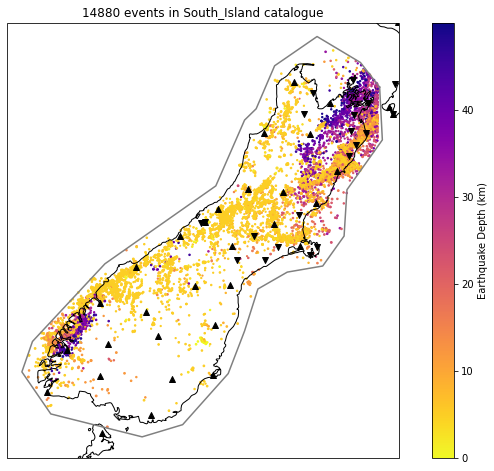

In [10]:
#Plot Catalogue
fig = plot_catalog(
    region=region, lats=lats, lons=lons, 
    mags=mags, depths=depths, poly=poly, splons=splons, 
    splats=splats, bblons=bblons, bblats=bblats)

#save figure
fig.savefig(f'plots/cat_map_{region}_{maxdepth}.eps', dpi=800, bbox_inches='tight')
fig.savefig(f'plots/cat_map_{region}_{maxdepth}.png', dpi=800, bbox_inches='tight')

## Plot Azimuthal Coverage

Make a plot of all the earthquakes, coloured by their maximum azimuthal gap (red shades: gap > 180 degrees, blue shades: gap < 180 degrees)

/home/emilyws/.local/lib/python3.6/site-packages/cartopy/crs.py:228: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  if len(multi_line_string) > 1:
/home/emilyws/.local/lib/python3.6/site-packages/cartopy/crs.py:280: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for line in multi_line_string:
/home/emilyws/.local/lib/python3.6/site-packages/cartopy/crs.py:347: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  if len(p_mline) > 0:
The PostScript backend does not support transparency; partially transparent art

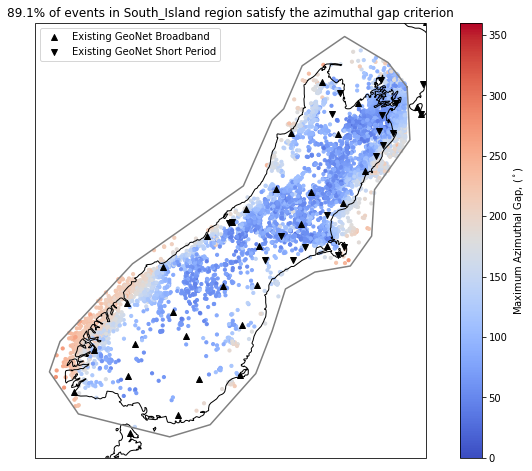

In [11]:
fig = plot_azimuthal_map(lats=lats, lons=lons, max_gap=max_gap, poly=poly, region=region,
                         bblons=bblons, bblats=bblats, splons=splons, splats=splats)


fig.savefig(f'plots/azimuthal_constraints_map_{region}_{maxdepth}.eps', dpi=800, bbox_inches='tight')
fig.savefig(f'plots/azimuthal_constraints_map_{region}_{maxdepth}.png', dpi=800, bbox_inches='tight')

## Plot Min_Distance Criteria

Make a plot showing the depth of each earthquake against distance to the closest picked station. Events plotting to the lower left of the solid black line have a station within one focal depth's distance. Same for dashed black line, but within 1.4* focal depth's distance. Events plotting to the right of both lines have no pick within 1.4* focal depth's distance.

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


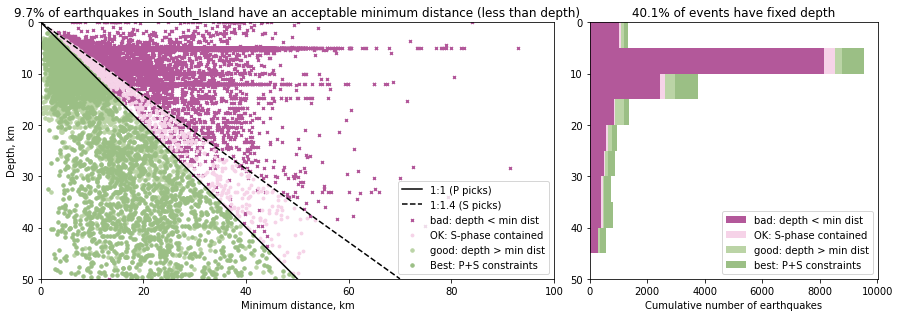

In [18]:
# Ascertain if s-pick exists within 1.4*depth epicentral distance for each event
#s_picks = min_spick_dist(cat_poly=cat_poly, inventory=inv)

# plot depth scatter plot
fig = plot_depth_scatter(min_dist=min_dist, s_picks=s_picks, depths=depths, fixed=fixed, region=region)

fig.savefig(f'plots/min_distance_constraints_{region}_{maxdepth}.eps', dpi=800, bbox_inches='tight')
fig.savefig(f'plots/min_distance_constraints_{region}_{maxdepth}.png', dpi=800, bbox_inches='tight')

## Calculate Criteria Scores and Quality Scores

Make a bar plot showing percentages of events satisfying each of the six quality criteria. Orange = pass criteria, peach = fail criteria.

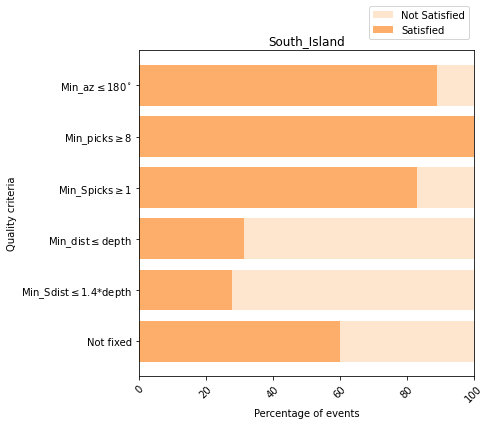

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


In [13]:
# Create binary counts for each quality criteria
# 1 indicates criteria satisfied, 0 indicates criteria not satisfied

min_az_bi, min_picks, ps, min_dist_bi, fixed_inv = binary_counts(max_gap=max_gap, cat_poly=cat_poly, 
                                                                 depths=depths, min_dist=min_dist, fixed=fixed)

# plot these up
fig, counts, criteria = plot_quality_criteria_scores(fixed_inv=fixed_inv, cat_poly=cat_poly, s_picks=s_picks, min_dist_bi=min_dist_bi,
                                 ps=ps, min_picks=min_picks, min_az_bi=min_az_bi, region=region)
fig.savefig(f'plots/quality_criteria_6_hist_{region}_{maxdepth}.eps', dpi=800, bbox_inches='tight')
fig.savefig(f'plots/quality_criteria_6_hist_{region}_{maxdepth}.png', dpi=800, bbox_inches='tight')


Print out these percentages to screen

In [14]:
from IPython.display import display, Latex

# Percentages of events satisfying each criteria:
print('Percentages of events satisfying each criteria:')
for i, c in enumerate(criteria):
    display(Latex(f"{c}: {counts[i]:.1f}"))

Percentages of events satisfying each criteria:


<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

/home/emilyws/.local/lib/python3.6/site-packages/cartopy/crs.py:228: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  if len(multi_line_string) > 1:
/home/emilyws/.local/lib/python3.6/site-packages/cartopy/crs.py:280: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for line in multi_line_string:
/home/emilyws/.local/lib/python3.6/site-packages/cartopy/crs.py:347: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  if len(p_mline) > 0:
The PostScript backend does not support transparency; partially transparent art

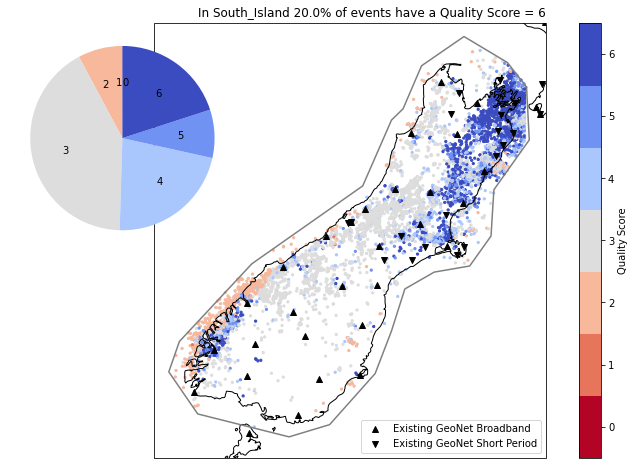

In [15]:
# calculate the percentage of scores and plot map and pie chart 
sums=[]
counts=[]
for i, ev in enumerate(cat_poly):
    sums.append(min_az_bi[i] + ps[i] + min_picks[i] + fixed_inv[i] + min_dist_bi[i] + s_picks[i])
quals=np.arange(0, 7, 1)
for n in quals:
    counts.append(sums.count(n))

## NOTE: if depth fixing is not used in selected catalogue, a 5-QS scoring system should be employed. 
## i.e. disregard QS6 and use QS5 as the mazimum possible score    

# plot map    
fig = plot_quality_score_map(
    quals=quals, counts=counts, lons=lons, lats=lats, region=region, poly=poly,
    cat_poly=cat_poly, sums=sums, bblons=bblons, bblats=bblats, splons=splons, splats=splats)

fig.savefig(f'plots/quality_constraints_6_map_{region}_{maxdepth}.eps', dpi=800, bbox_inches='tight')
fig.savefig(f'plots/quality_constraints_6_map_{region}_{maxdepth}.png', dpi=800, bbox_inches='tight')

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


Final Quality Score Percentages for South_Island region are:
QS0: 0.0
QS1: 0.1
QS2: 7.7
QS3: 41.7
QS4: 22.0
QS5: 8.5
QS6: 20.0


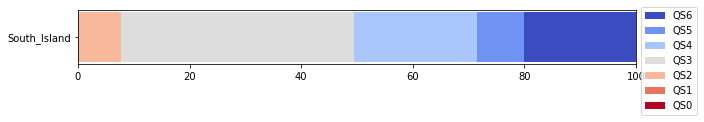

In [16]:
# Extract the percentages for each QS and also plot as bar chart

countspc, countspc_cum=[],[]
for c in counts:
    countspc.append(c/len(sums)*100)
countspc_cum=np.cumsum(countspc)

print('Final Quality Score Percentages for ' + region + ' region are:')
for i, QS in enumerate(['QS0', 'QS1', 'QS2', 'QS3', 'QS4', 'QS5', 'QS6']):
    print(QS + ': ' + str(round(countspc[i],1)))

# plot as bar chart

fig=plot_quality_score_bar(region=region, countspc_cum=countspc_cum, quals=quals)
    
fig.savefig(f'plots/quality_constraints_6_barchart_{region}_{maxdepth}.eps', dpi=800, bbox_inches='tight')
fig.savefig(f'plots/quality_constraints_6_barchart_{region}_{maxdepth}.png', dpi=800, bbox_inches='tight')

Finally, write out the catalogue with the Quality Score saved within the preferred origin's comments

In [71]:
(origin.comments.append(Comment(text=f"Quality score: {quality_score}")))

NameError: name 'origin' is not defined